In [ ]:
import os 
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn import model_selection
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# To show off progress
tqdm.pandas()

In [ ]:
# Function to load the dataframe
def load_df(path, _extensions = ['jpg', 'jpeg']):
    x, y = [], []
    
    # Iterate through the train, validation, test folders
    for subdir in ['train', 'validation', 'test']:  # Loop through each folder
        subdir_path = os.path.join(path, subdir)
        
        for dirname, _, filenames in tqdm(os.walk(subdir_path)):
            for filename in filenames:
                extension = filename.split('.')
                if len(extension) > 1 and extension[1] in _extensions:
                    x.append(os.path.join(dirname, filename))  # Add the image path
                    y.append(dirname.split(os.path.sep)[-1])   # Add the class (folder name)
    
    # Create the dataframe
    dataset = {
        'image': x,
        'label': y
    }
    
    return pd.DataFrame(dataset)

# Path to the folder containing data
path = r'C:\Users\Irenchik\OneDrive\Робочий стіл\Winstars_test\task_2\img_model\data'

# Load the dataframe
df = load_df(path)

# Check the size and display the first few rows
print(df.shape)
print(df.head())

# Save the dataframe to a CSV file
df.to_csv(r'C:\Users\Irenchik\OneDrive\Робочий стіл\Winstars_test\task_2\img_model\Multi_Class_Animal_Classification.csv', index=False)

13it [00:00, 96.50it/s]
13it [00:00, 307.04it/s]
13it [00:00, 569.85it/s]

(17154, 2)
                                               image      label
0  C:\Users\Irenchik\Downloads\image_classificati...  butterfly
1  C:\Users\Irenchik\Downloads\image_classificati...  butterfly
2  C:\Users\Irenchik\Downloads\image_classificati...  butterfly
3  C:\Users\Irenchik\Downloads\image_classificati...  butterfly
4  C:\Users\Irenchik\Downloads\image_classificati...  butterfly


In [17]:
# Importing dataset
df = pd.read_csv('C:\Users\Irenchik\OneDrive\Робочий стіл\Winstars_test\task_2\img_model\Multi_Class_Animal_Classification.csv')
print(df.label.unique())
print(df.shape)
df.head()

['butterfly' 'cat' 'cow' 'dog' 'elephant' 'hen' 'horse' 'monkey' 'panda'
 'sheep' 'spider' 'squirrel']
(17154, 2)


,image,label
0,C:\Users\Irenchik\Downloads\image_classificati...,butterfly
1,C:\Users\Irenchik\Downloads\image_classificati...,butterfly
2,C:\Users\Irenchik\Downloads\image_classificati...,butterfly
3,C:\Users\Irenchik\Downloads\image_classificati...,butterfly
4,C:\Users\Irenchik\Downloads\image_classificati...,butterfly


In [18]:
# Show image by its label (label inertpreter)
def show_image_bylabel(df, label, index = 0):    
    df_label = df[df['label'] == label]
    print(f'{df_label.shape[0]} sample')
    
    plt.imshow(plt.imread(df_label['image'].iloc[index]))
    plt.xlabel(label)

In [ ]:
# After the loading is complete
print(f'Загальна кількість зображень: {df.shape[0]}')
print(f'Кількість зображень по кожному класу:\n{df["label"].value_counts()}')


Загальна кількість зображень: 17154
Кількість зображень по кожному класу:
label
cat          1456
dog          1456
hen          1455
horse        1455
sheep        1455
squirrel     1455
cow          1454
monkey       1453
spider       1453
elephant     1445
butterfly    1414
panda        1203
Name: count, dtype: int64


1203 sample


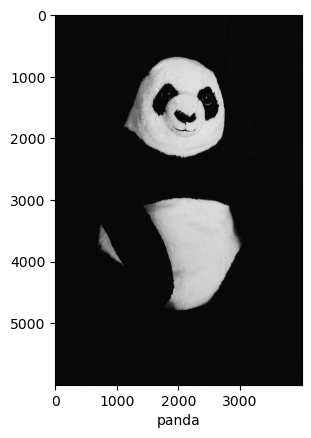

In [20]:
show_image_bylabel(df, 'panda', 30)

In [21]:
# Grouping by labels, and counting its existence
df_label_counts = df[['image', 'label']].groupby('label').count().reset_index()
df_label_counts.columns = ['label', 'count']
df_label_counts.shape

def bar_distribution_plot(min_val, max_val):
    # Displaying labels above min_val image
    df_label_counts_minval = df_label_counts[(df_label_counts['count'] >= min_val) & (df_label_counts['count'] < max_val)]
    print(f'{df_label_counts_minval.shape[0]} category, {df_label_counts_minval.label.unique()}')
    df_label_counts_minval.plot.barh(x='label', y='count')
    plt.show()

12 category, ['butterfly' 'cats' 'cow' 'dogs' 'elephant' 'hen' 'horse' 'monkey' 'panda'
 'sheep' 'spider' 'squirrel']


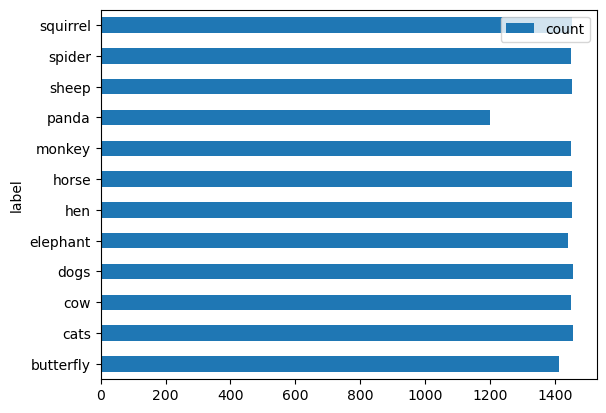

In [10]:
# Displaying labels in range [1000, 5000] image
bar_distribution_plot(min_val=1000, max_val=2000)

In [ ]:
# Adding a new feature to detect replicas
df['filename'] = df['image'].apply(lambda x: os.path.basename(x))

# Check the shape of the dataframe and display the first few rows
print(df.shape)
df.head()

(17154, 3)


,image,label,filename
0,C:\Users\Irenchik\Downloads\image_classificati...,butterfly,e030b20929e90021d85a5854ee454296eb70e3c818b413...
1,C:\Users\Irenchik\Downloads\image_classificati...,butterfly,e030b2092de90021d85a5854ee454296eb70e3c818b413...
2,C:\Users\Irenchik\Downloads\image_classificati...,butterfly,e030b20a20e90021d85a5854ee454296eb70e3c818b413...
3,C:\Users\Irenchik\Downloads\image_classificati...,butterfly,e134b50a2efc1c22d2524518b7444f92e37fe5d404b014...
4,C:\Users\Irenchik\Downloads\image_classificati...,butterfly,e831b10b2ee90021d85a5854ee454296eb70e3c818b413...


In [ ]:
# Function to convert and save an image
def convert_save_image(src_path, dest_path):
    try:
        # Open the image
        with Image.open(src_path) as img:
            img = img.convert('RGB')  # Convert to RGB (for JPEG format)

            # Save the image in JPEG format
            img.save(dest_path, 'JPEG')
            
    except Exception as e:
        print(f"Error: {e}")

# Create a new directory to store processed images
os.makedirs("C:\\Users\\Irenchik\\OneDrive\\Робочий стіл\\Winstars_test\\task_2\\img_model\\prepared_data", exist_ok=True)

# Convert and save images
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    _filename = row['filename'].split('.')[0] # Get the file name without extension
    os.makedirs(f"C:\\Users\\Irenchik\\OneDrive\\Робочий стіл\\Winstars_test\\task_2\\img_model\\prepared_data\\{row['label']}", exist_ok=True) # Create a folder for the class  
    
    # Define the source image path
    src_image_path = row['image']
    
    # Define the destination path to save the image in .jpeg format
    dest_image_path = f"C:\\Users\\Irenchik\\OneDrive\\Робочий стіл\\Winstars_test\\task_2\\img_model\\prepared_data\\{row['label']}\\{_filename}.jpeg"
    
    # Convert and save the image
    convert_save_image(src_image_path, dest_image_path)


100%|████████████████████████████████████████████████████████████████████████████| 17154/17154 [04:16<00:00, 66.79it/s]


In [24]:
# Extracting features and target
x = df[['image']]
y = df[['label']]

print(x.shape, y.shape)

(17154, 1) (17154, 1)


In [25]:
# Split into training, validation, and testing data [70%, 15%, 15%]
x_train, x, y_train, y = model_selection.train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = model_selection.train_test_split(x, y, test_size=0.5, stratify=y, random_state=42)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(12007, 1) (12007, 1) (2573, 1) (2573, 1) (2574, 1) (2574, 1)


In [26]:
# OneHotEncoding the target
y_train = pd.get_dummies(y_train['label'], dtype=int)
y_val = pd.get_dummies(y_val['label'], dtype=int)
y_test = pd.get_dummies(y_test['label'], dtype=int)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(12007, 1) (12007, 12) (2573, 1) (2573, 12) (2574, 1) (2574, 12)


In [27]:
# To Interpret the prediction result
_columns = y_train.columns 
print(_columns)

def get_category(y_hat, cols = _columns):
    max_value = y_hat.max()
    for index, category in enumerate(y_hat):
        if category == max_value:
            return cols[index]
    
    return 'unknown'

Index(['butterfly', 'cat', 'cow', 'dog', 'elephant', 'hen', 'horse', 'monkey',
       'panda', 'sheep', 'spider', 'squirrel'],
      dtype='object')


In [28]:
# For example
get_category(y_train.iloc[24])

'monkey'

In [ ]:
# image dimension
width = height = 256
print(f'image dimension ({width}, {height})')

image dimension (256, 256)


In [30]:
def read_image(img_path, label = -1, expand_dim=False):    
    img = tf.io.read_file(tf.squeeze(img_path))
    img = tf.image.decode_jpeg(img, channels=3)
    
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (width, height))
    img = tf.clip_by_value(img, 0.0, 1.0) # aka pixel/255
    
    if expand_dim:
        img = tf.expand_dims(img, 0)  # Add batch dimension
    
    return img, label

In [ ]:
_batch_size = 32  

def tensor_slices_dataset(x, y, batch_size=_batch_size, shuffle_size=160_000, training=False):
    # Create a TensorFlow dataset from tensors (x, y)
    data = tf.data.Dataset.from_tensor_slices((x, y))
    # Shuffle the dataset with the specified shuffle size
    data = data.shuffle(shuffle_size)
    
    # Apply image reading function
    data = data.map(read_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)    
    # Apply augmentation only if training is True
    if training:
        data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)  

    # Batch the data with the specified batch size
    data = data.batch(batch_size)
    # Prefetch the data for better performance during training
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    
    return data

In [ ]:
# Create the TensorFlow dataset for train data
train_tensor = tensor_slices_dataset(x_train, y_train, training=False)  # Set training=False to skip augmentation

In [ ]:
# Create the TensorFlow dataset for validation data
val_tensor = tensor_slices_dataset(x_val, y_val)
# Create the TensorFlow dataset for test data
test_tensor = tensor_slices_dataset(x_test, y_test)

In [ ]:
# Sample one batch from the training dataset
train_tensor.take(1) 

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.int32, name=None))>

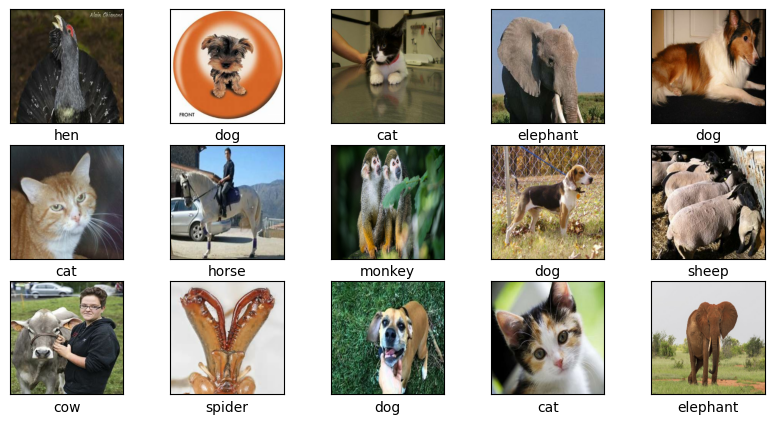

In [ ]:
for x, y in train_tensor.take(1): # Loop through the sample batch
    plt.figure(figsize=(10,5)) # Set up the plot size
    
    for i in range(15): # Loop through the first 15 images in the batch               
        plt.subplot(3, 5, i+1) # Create a 3x5 grid of subplots
        plt.imshow(x[i]) # Display the image
        
        plt.xlabel(get_category(np.array(y[i]))) # Add the category label (prediction) based on the target variable
        plt.xticks([]) # Remove x-axis ticks
        plt.yticks([]) # Remove y-axis ticks

In [ ]:
# Load pre-trained InceptionV3 model without the top layer (no classification)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add new layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce the spatial dimensions
x = Dense(512, activation='relu')(x)  # Another fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.6)(x)   # Dropout to reduce overfitting 
output_layer = tf.keras.layers.Dense(units=_columns.shape[0], activation='softmax')(x) # sigmoid for binary classes, softmax for multiclasses

# Create the new model
model = Model(inputs=base_model.input,  outputs=[output_layer])

# Freeze weights of the pre-trained model to avoid retraining them during fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to stop training if the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Show model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 127, 127, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 127, 127, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 127, 127, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 125, 125, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 125, 125, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 125, 125, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 125, 125, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 125, 125, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 125, 125, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 62, 62, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 62, 62, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 62, 62, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 62, 62, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 60, 60, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,860,076 (87.20 MB)

 Trainable params: 1,056,268 (4.03 MB)

 Non-trainable params: 21,803,808 (83.17 MB)

In [37]:
# Training model
history = model.fit(train_tensor,
          batch_size=_batch_size,
          epochs=6,
          validation_data=val_tensor,
          callbacks = [early_stopping, reduce_lr])

Epoch 1/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 970s 3s/step - accuracy: 0.7242 - loss: 1.0236 - val_accuracy: 0.9627 - val_loss: 0.1419 - learning_rate: 1.0000e-04
Epoch 2/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 990s 3s/step - accuracy: 0.9475 - loss: 0.1838 - val_accuracy: 0.9693 - val_loss: 0.1280 - learning_rate: 1.0000e-04
Epoch 3/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 942s 3s/step - accuracy: 0.9641 - loss: 0.1295 - val_accuracy: 0.9650 - val_loss: 0.1339 - learning_rate: 1.0000e-04
Epoch 4/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 991s 3s/step - accuracy: 0.9691 - loss: 0.1059 - val_accuracy: 0.9681 - val_loss: 0.1242 - learning_rate: 1.0000e-04
Epoch 5/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.9743 - loss: 0.0844 - val_accuracy: 0.9662 - val_loss: 0.1237 - learning_rate: 1.0000e-04
Epoch 6/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 1174s 3s/step - accuracy: 0.9781 - loss: 0.0729 - val_accuracy: 0.9693 - val_loss: 0.1267 - learning_rate: 1.0000e-04


In [ ]:
# Testing the model
test_loss, test_accuracy = model.evaluate(test_tensor)

# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

81/81 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9733 - loss: 0.0744
Test loss: 0.0844. Test accuracy: 97.16%


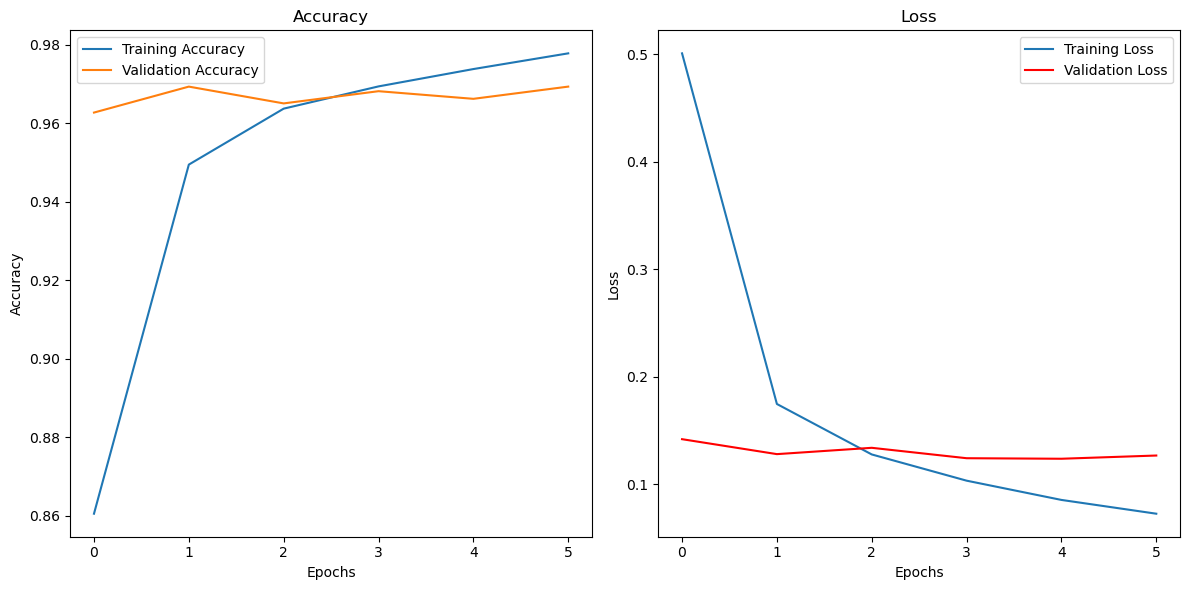

In [ ]:
# Plot accuracy for training and validation data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss for training and validation data
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
# Load the model
model.save("C:\\Users\\Irenchik\\OneDrive\\Робочий стіл\\Winstars_test\\task_2\\img_model\\img_classification_model.h5")